In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [481]:
def ferguson_theta_ode(s_max, eps_factor, k, h, omega):
    """
    Implementation of  (Ferguson, 1976, Eq.9).
    The equation is formulated as an initial value problem and integrated with scipy function for integration (solve_ivp)
    http://onlinelibrary.wiley.com/doi/10.1002/esp.3290010403/full

    Parameters:
        s_max: 	max length of channel
        k:		Wavenumber
        h:		Height
        eps_factor:	Random background noise (normal variance)
        omega: initial angle

    Returns:
        theta : angle array
        s : channel distance array

    """

    # Correlated variance calculation => Gaussian function
    s_range = np.arange(0, s_max, (s_max / 1000))
    dist_arr = scipy.spatial.distance.pdist(
        np.expand_dims(s_range, axis=1), "sqeuclidean"
    )
    variance = eps_factor
    cov = variance * np.exp(-(1 / 2) * dist_arr)

    cov = scipy.spatial.distance.squareform(cov)
    cov[np.diag_indices_from(cov)] = variance
    u = np.random.multivariate_normal(
        np.zeros_like(s_range), np.eye((s_range).shape[0])
    )
    L = scipy.linalg.cholesky(cov)
    e_s = L @ u

    def rhs(t, y, k, h):
        eps_t = np.interp(np.array([t]), s_range, e_s)
        eps_t = eps_t[0]  # from array to float
        d_tau_ds = (eps_t - y[1] - 2 * h / k * y[0]) * (k**2)
        d_theta_ds = y[0]
        dx_ds = np.cos(y[1])
        dy_ds = np.sin(y[1])
        return np.array([d_tau_ds, d_theta_ds, dx_ds, dy_ds])

    def jac(t, y, k, h):
        return np.array(
            [
                [-2 * h * k, -(k**2), 0, 0],
                [1, 0, 0, 0],
                [0, -np.sin(y[1]), 0, 0],
                [0, np.cos(y[1]), 0, 0],
            ]
        )

    y0 = np.array([omega * k, 0.0, 0.0, 0.0])

    solution = scipy.integrate.solve_ivp(
        rhs,
        (0, s_max),
        y0,
        method="BDF",
        args=(k, h),
        first_step=0.01,
        jac=jac,
        atol=1e-8,
        rtol=1e-8,
    )

    y = solution.y

    s = solution.t

    tau = y[0, :]
    theta = y[1, :]
    x = y[2, :]
    y = y[3, :]

    return theta, s, x, y, tau

In [482]:
h = 0.1
k = np.pi / 200
eps_factor = (np.pi / 1.5) ** 2
s_max = 1000

In [483]:
ferguson_theta_ode(s_max, eps_factor, k, h, 0.0)

(array([ 0.00000000e+00, -1.43915112e-08, -3.65999873e-08, ...,
         9.91729815e-02,  9.97235214e-02,  1.01003814e-01]),
 array([0.00000000e+00, 1.00000000e-02, 1.79921235e-02, ...,
        9.99661605e+02, 9.99763195e+02, 1.00000000e+03]),
 array([0.00000000e+00, 1.00000000e-02, 1.79921235e-02, ...,
        9.81508041e+02, 9.81609128e+02, 9.81844742e+02]),
 array([ 0.00000000e+00, -1.21447352e-10, -3.83565598e-10, ...,
         2.64438339e+00,  2.65446965e+00,  2.67819647e+00]),
 array([ 0.00000000e+00, -1.70539408e-06, -3.02662964e-06, ...,
         5.42307603e-03,  5.41544155e-03,  5.39760132e-03]))

In [484]:
theta, s, x, y, tau = ferguson_theta_ode(s_max, eps_factor, k, h, 0.0)

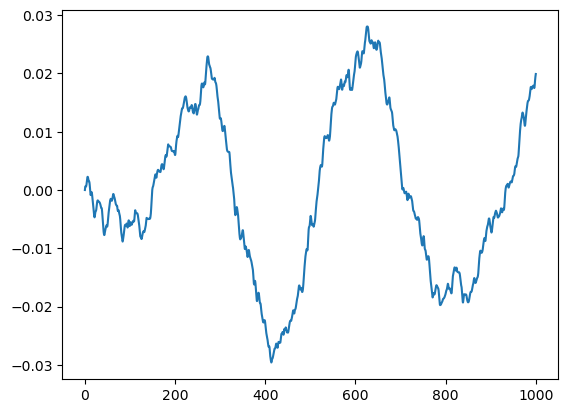

In [485]:
plt.plot(s, tau)

In [486]:
dTdtheta = np.array([-np.sin(theta), np.cos(theta)])

In [487]:
dTdtheta

array([[-0.00000000e+00, -3.01785834e-08, -9.50925239e-08, ...,
         4.24558018e-01,  4.19305643e-01,  4.19177828e-01],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         9.05400734e-01,  9.07845129e-01,  9.07904152e-01]])

In [488]:
dTdtheta.shape

(2, 13230)

In [489]:
dTdtheta * tau[np.newaxis,]

array([[-0.00000000e+00, -1.96280620e-13, -1.23378854e-12, ...,
         8.37879250e-03,  8.34453874e-03,  8.34367106e-03],
       [ 0.00000000e+00,  6.50397064e-06,  1.29746114e-05, ...,
         1.78683821e-02,  1.80668898e-02,  1.80716944e-02]])

In [490]:
dTds = dTdtheta * tau[np.newaxis,]

In [491]:
np.sum(dTds**2, axis=0)

array([0.00000000e+00, 4.23016341e-11, 1.68340541e-10, ...,
       3.89483242e-04, 3.96043834e-04, 3.96202984e-04])

In [492]:
np.sqrt(np.sum(dTds**2, axis=0))

array([0.00000000e+00, 6.50397064e-06, 1.29746114e-05, ...,
       1.97353298e-02, 1.99008501e-02, 1.99048483e-02])

In [493]:
curv = np.sqrt(np.sum(dTds**2, axis=0))

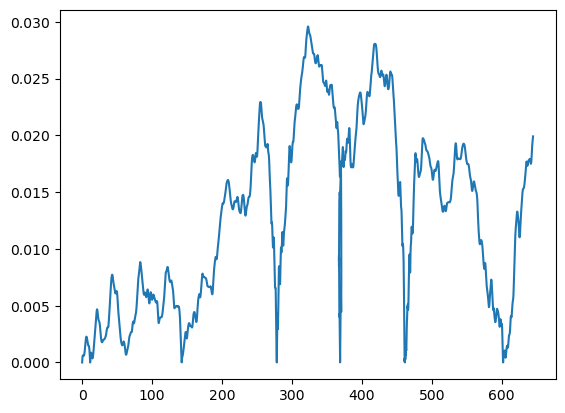

In [494]:
plt.plot(x, curv)

In [495]:
dx = np.gradient(x, s)
dy = np.gradient(y, s)
d2x = np.gradient(dx, s)
d2y = np.gradient(dy, s)
curvature = np.abs(d2x * dy - dx * d2y) / (dx**2 + dy**2) ** (3 / 2)

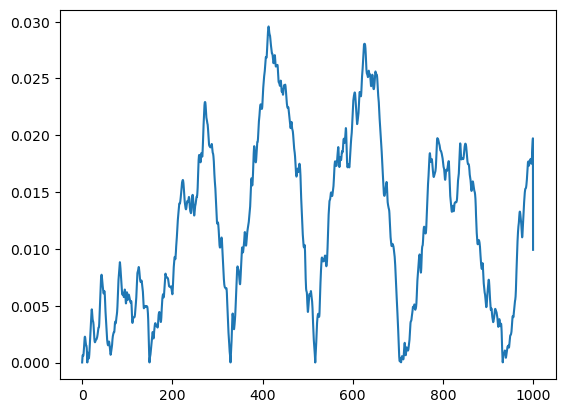

In [496]:
plt.plot(s, curvature)

In [564]:
def R_1(
    s: float,
    s_arr: np.ndarray,
    curv_arr: np.ndarray,
    k_1: float,
    Cf: float,
    W: float,
    D: float,
    Omega=-1,
    F=2.5,
):
    # interpolate to find the value of tau at s
    tau = np.interp(s, s_arr, curv_arr)
    Ro = k_1 * (tau * W)
    s_prime = np.where(s_arr < s, s_arr, 0)
    s_prime = s_prime[s_prime != 0]
    curv_prime = curv_arr[: len(s_prime)]
    s_prime = np.concatenate((s_prime, [s]))
    curv_prime = np.concatenate((curv_prime, [tau]))
    sau = s - s_prime
    G_sau = np.exp(-2 * Cf * sau / D)
    Ro_prime = k_1 * (curv_prime * W)
    index = np.where(np.abs(G_sau) > 1e-13)
    index = index[0]
    G_sau = G_sau[index]
    Ro_prime = Ro_prime[index]
    sau = sau[index]
    G_sau = np.flip(G_sau)
    Ro_prime = np.flip(Ro_prime)
    sau = np.flip(sau)
    integration = np.trapz(Ro_prime * G_sau, sau) / (1 / (2 * Cf / D))
    return Omega * Ro + F * integration


def Rs(s_arr, curv_arr, k_1, W, Cf, D, Omega=-1, F=2.5):
    Rs_arr = np.zeros(len(s_arr))
    for i in range(len(s_arr)):
        Rs_arr[i] = R_1(s_arr[i], s_arr, curv_arr, k_1, Cf, W, D, Omega, F)
    return Rs_arr

In [565]:
def channel_migration(
    x, y, s, calc_step, return_steps, ds, dt, k_1, W, Cf, D, Omega=-1, F=2.5
):
    xs = []
    ys = []
    ss = []
    for i in range(calc_step):
        # resample x,y,s
        s_r = np.arange(0, s[-1], ds)
        x = np.interp(s_r, s, x)
        y = np.interp(s_r, s, y)
        # calculate curvature
        dx = np.gradient(x, s_r)
        dy = np.gradient(y, s_r)
        d2x = np.gradient(dx, s_r)
        d2y = np.gradient(dy, s_r)
        curvature = np.abs(d2x * dy - dx * d2y) / (dx**2 + dy**2) ** (3 / 2)
        # calculate Rs
        Rs_arr = Rs(s_r, curvature, k_1, W, Cf, D, Omega, F)
        # update x,y
        x = x + dt * Rs_arr * dx
        y = y - dt * Rs_arr * dy
        dfx = np.diff(x, prepend=0)
        dfy = np.diff(y, prepend=0)
        s = np.cumsum(np.sqrt(dfx**2 + dfy**2))
        if int(i) % int(return_steps) == 0:
            xs.append(x)
            ys.append(y)
            ss.append(s)
    return xs, ys, ss

In [577]:
dfx = np.diff(x, prepend=0)
dfy = np.diff(y, prepend=0)
s = np.cumsum(np.sqrt(dfx**2 + dfy**2))
s.shape

(200,)

In [580]:
k_1 = 60.0 / (365 * 24 * 60 * 60.0)
W = 5
D = 0.9
Cf = 0.0011
dt = 0.1 * 365 * 24 * 3600
ds = 5
xs, ys, ss = channel_migration(x, y, s, 10, 1, ds, dt, k_1, W, Cf, D, Omega=-1, F=2.5)

ValueError: fp and xp are not of the same length.

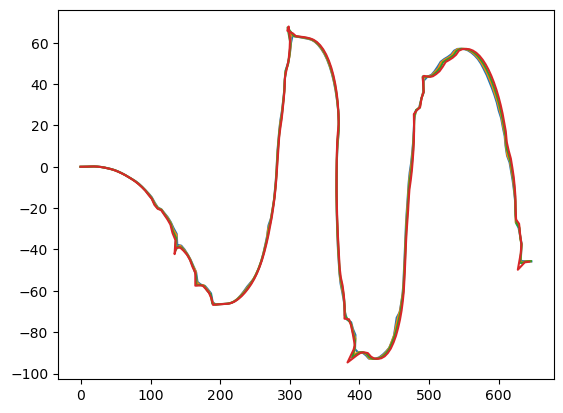

In [579]:
for x, y in zip(xs, ys):
    plt.plot(x, y)

In [498]:
tau = np.interp(500, s, curvature)
Ro = k_1 *tau * W
s_prime = np.where(s < 500, s, 0)
s_prime = s_prime[s_prime != 0]
curv_prime = curvature[:len(s_prime)]
s_prime = np.concatenate((s_prime, [500]))
curv_prime = np.concatenate((curv_prime, [tau]))
sau = 500 - s_prime
G_sau = np.exp(-2* Cf * sau/D)
Ro_prime = k_1 * curv_prime * W
index = np.where(G_sau>1e-13)
index = index[0]

G_sau = G_sau[index]
Ro_prime = Ro_prime[index]
sau = sau[index]
G_sau = np.flip(G_sau)
Ro_prime = np.flip(Ro_prime)
sau = np.flip(sau)
integration = np.trapz(Ro_prime * G_sau, sau)/(1/(2*Cf/D))

In [499]:
Ro

4.4923352150849947e-07

In [500]:
print(Ro_prime)
print(Ro)

[4.49233522e-07 4.53682958e-07 4.59334656e-07 ... 1.59330513e-09
 9.27094822e-10 5.08475132e-10]
4.4923352150849947e-07


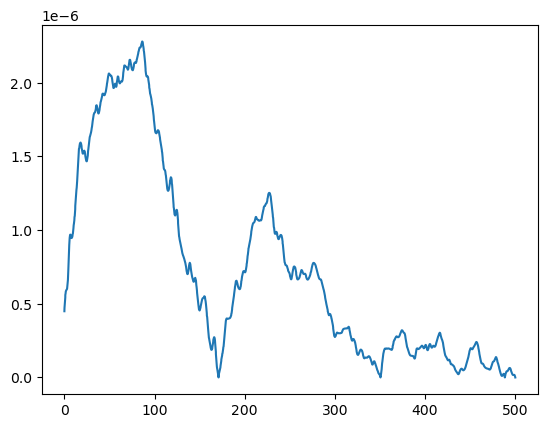

In [501]:
plt.plot(sau, Ro_prime * G_sau)

In [502]:
index = np.where(np.abs(G_sau) > 1e-13)
index

(array([   0,    1,    2, ..., 6718, 6719, 6720], dtype=int64),)

In [503]:
k_1 = 600.0 / (365 * 24 * 60 * 60.0)

In [504]:
W = 5
D = 0.9

In [505]:
Cf = 0.0011

In [506]:
Rss = Rs(s, curvature, k_1, W, Cf, D)

In [507]:
Rss

array([-5.08475132e-10, -9.27094822e-10, -1.59326982e-09, ...,
        7.91580446e-07,  1.70368251e-06,  1.72671203e-06])

In [548]:
sinuosity = s / x

C:\Users\vcant\AppData\Local\Temp\ipykernel_21656\301999085.py:1: RuntimeWarning: invalid value encountered in divide
  sinuosity = s/x


In [549]:
Rss = Rss * sinuosity ** (-2 / 3)

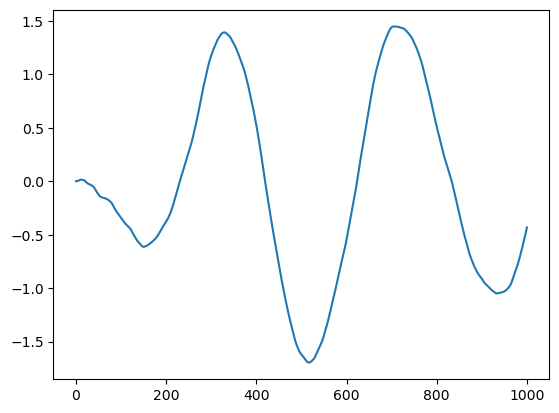

In [550]:
plt.plot(s, theta)

In [551]:
dxds = np.cos(theta)
dyds = np.sin(theta)

In [552]:
x2 = x + Rss * dx * 0.1 * 365 * 24 * 3600
y2 = y - Rss * dy * 0.1 * 365 * 24 * 3600

In [553]:
x2

array([           nan, 2.57474306e-03, 5.97232289e-03, ...,
       6.45690303e+02, 6.47413295e+02, 6.47456538e+02])

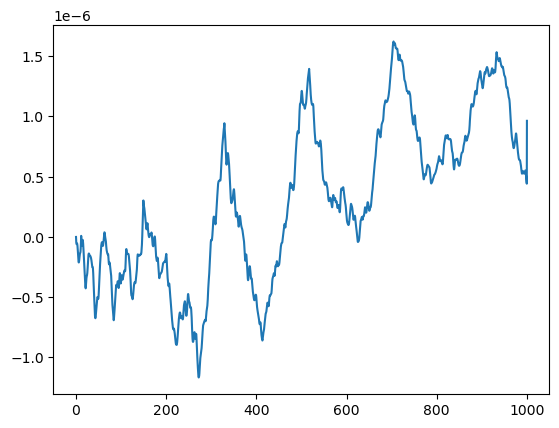

In [554]:
plt.plot(s, Rss)

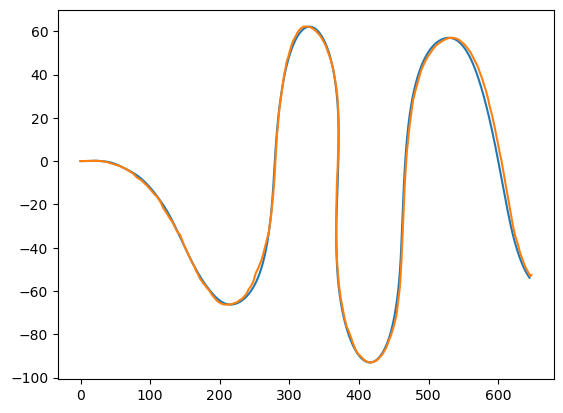

In [555]:
plt.plot(x, y)
plt.plot(x2, y2)

The euler method for integration will suck this way. Maybe the implicit Euler works better.

In [464]:
# Correlated variance calculation => Gaussian function
np.random.seed(33333)
s_max = 1000
s_range = np.arange(0, s_max, (s_max / 1000))
dist_arr = scipy.spatial.distance.pdist(np.expand_dims(s_range, axis=1), "sqeuclidean")
variance = eps_factor
cov = variance * np.exp(-(1 / 2) * dist_arr)

cov = scipy.spatial.distance.squareform(cov)
cov[np.diag_indices_from(cov)] = variance
u = np.random.multivariate_normal(np.zeros_like(s_range), np.eye((s_range).shape[0]))
L = scipy.linalg.cholesky(cov)
e_s = L @ u


def ferguson_theta_ode_noise(s_max, eps_arr, k, h, omega):
    """
    Implementation of  (Ferguson, 1976, Eq.9).
    The equation is formulated as an initial value problem and integrated with scipy function for integration (solve_ivp)
    http://onlinelibrary.wiley.com/doi/10.1002/esp.3290010403/full

    Parameters:
        s_max: 	max length of channel
        k:		Wavenumber
        h:		Height
        eps_factor:	Random background noise (normal variance)
        omega: initial angle

    Returns:
        theta : angle array
        s : channel distance array

    """

    def rhs(t, y, k, h):
        eps_t = np.interp(np.array([t]), s_range, eps_arr)
        eps_t = eps_t[0]  # from array to float
        d_tau_ds = (eps_t - y[1] - 2 * h / k * y[0]) * (k**2)
        d_theta_ds = y[0]
        dx_ds = np.cos(y[1])
        dy_ds = np.sin(y[1])
        return np.array([d_tau_ds, d_theta_ds, dx_ds, dy_ds])

    def jac(t, y, k, h):
        return np.array(
            [
                [-2 * h * k, -(k**2), 0, 0],
                [1, 0, 0, 0],
                [0, -np.sin(y[1]), 0, 0],
                [0, np.cos(y[1]), 0, 0],
            ]
        )

    y0 = np.array([omega * k, 0.0, 0.0, 0.0])

    solution = scipy.integrate.solve_ivp(
        rhs,
        (0, s_max),
        y0,
        method="BDF",
        args=(k, h),
        first_step=0.01,
        jac=jac,
        atol=1e-8,
        rtol=1e-8,
    )

    y = solution.y

    s = solution.t

    tau = y[0, :]
    theta = y[1, :]
    x = y[2, :]
    y = y[3, :]

    return theta, s, x, y, tau

In [465]:
theta, s, x, y, tau = ferguson_theta_ode_noise(s_max, e_s, k, h, 0.0)

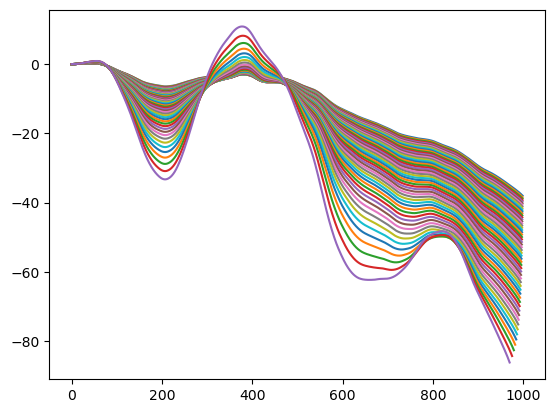

In [472]:
for h in np.linspace(5.5, 0.6, 55):
    theta, s, x, y, tau = ferguson_theta_ode_noise(s_max, e_s, k, h, 0.0)
    plt.plot(x, y)

In [471]:
y

array([ 0.00000000e+00,  1.09799151e-10,  4.71650896e-10, ...,
       -3.79796112e+01, -3.79966147e+01, -3.80211729e+01])